In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [2]:
db_user = 'postgres'
db_password = '123456'
db_host = 'localhost'
db_port = '5432'
db_name = 'nordic_co2'

engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# Sweden

## General Analysis

In [3]:
query_se_general = '''
WITH se_2021_summary AS (
    SELECT 
        '2021' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM sweden.year_2021_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), se_2022_summary AS (
    SELECT 
        '2022' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM sweden.year_2022_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), se_2023_summary AS (
    SELECT 
        '2023' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM sweden.year_2023_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), se_2024_summary AS (
    SELECT 
        '2024' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM sweden.year_2024_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), total_summary AS (
    SELECT * FROM se_2021_summary
    UNION ALL
    SELECT * FROM se_2022_summary
    UNION ALL
    SELECT * FROM se_2023_summary
    UNION ALL
    SELECT * FROM se_2024_summary
), with_differences AS (
    SELECT 
        *,
        LEAD(total_direct_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, month_grouped) AS next_direct_carbon_emission,
        LEAD(total_lca_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, month_grouped) AS next_lca_carbon_emission
    FROM total_summary
)

SELECT 
    year_,
    country,
    zone_id,
    month_grouped,
    total_direct_carbon_emission,
    next_direct_carbon_emission,
    CASE 
        WHEN next_direct_carbon_emission IS NOT NULL AND total_direct_carbon_emission != 0 
        THEN ROUND(((next_direct_carbon_emission - total_direct_carbon_emission) / total_direct_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS direct_decrease_or_increase,
    total_lca_carbon_emission,
    next_lca_carbon_emission,
    CASE 
        WHEN next_lca_carbon_emission IS NOT NULL AND total_lca_carbon_emission != 0 
        THEN ROUND(((next_lca_carbon_emission - total_lca_carbon_emission) / total_lca_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS lca_decrease_or_increase,
    avg_renewable_percentage,
    avg_low_carbon_percentage
FROM with_differences
ORDER BY year_, month_grouped;
'''

se_general = pd.read_sql_query(query_se_general, engine)

In [4]:
se_general.head()

,year_,country,zone_id,month_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Sweden,SE,1.0,6077.28,8227.87,35.39,25788.29,26830.34,4.04,70.26,98.68
1,2021,Sweden,SE,2.0,8227.87,3315.57,-59.70,26830.34,22847.66,-14.84,69.36,98.14
2,2021,Sweden,SE,3.0,3315.57,2704.52,-18.43,22847.66,21324.25,-6.67,68.81,99.13
3,2021,Sweden,SE,4.0,2704.52,3829.70,41.60,21324.25,23180.54,8.71,69.06,99.26
4,2021,Sweden,SE,5.0,3829.70,2783.95,-27.31,23180.54,21351.22,-7.89,69.87,99.04


In [5]:
se_general.rename(columns={'year_':'year'}, inplace=True)
se_general.rename(columns={'month_grouped':'month'}, inplace=True)

In [6]:
se_general.dtypes

year                             object
country                          object
zone_id                          object
month                           float64
total_direct_carbon_emission    float64
next_direct_carbon_emission     float64
direct_decrease_or_increase     float64
total_lca_carbon_emission       float64
next_lca_carbon_emission        float64
lca_decrease_or_increase        float64
avg_renewable_percentage        float64
avg_low_carbon_percentage       float64
dtype: object

In [7]:
se_general.year = se_general.year.astype(int)
se_general.month = se_general.month.astype(int)

### Statistics

In [8]:
se_general.describe()

,year,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
count,48.000000,48.000000,48.000000,47.000000,47.000000,48.000000,47.000000,47.000000,48.000000,48.000000
mean,2022.500000,6.500000,3091.929375,3028.411277,13.214468,18580.140833,18426.775957,0.529149,69.382917,99.421875
std,1.129865,3.488583,1939.797353,1909.645454,67.084759,4508.498363,4428.870969,19.135424,2.227805,0.382615
min,2021.000000,1.000000,718.340000,718.340000,-62.010000,10891.670000,10891.670000,-30.500000,62.330000,98.140000
25%,2021.750000,3.750000,1940.547500,1924.855000,-31.325000,14782.770000,14769.450000,-13.040000,68.532500,99.252500
50%,2022.500000,6.500000,2682.160000,2659.800000,-17.530000,18494.010000,18406.990000,-4.680000,69.565000,99.535000
75%,2023.250000,9.250000,3536.420000,3470.845000,38.250000,21371.462500,21337.735000,7.355000,70.777500,99.690000
max,2024.000000,12.000000,9139.680000,9139.680000,199.280000,28853.640000,28853.640000,56.910000,73.090000,99.890000


<Axes: >

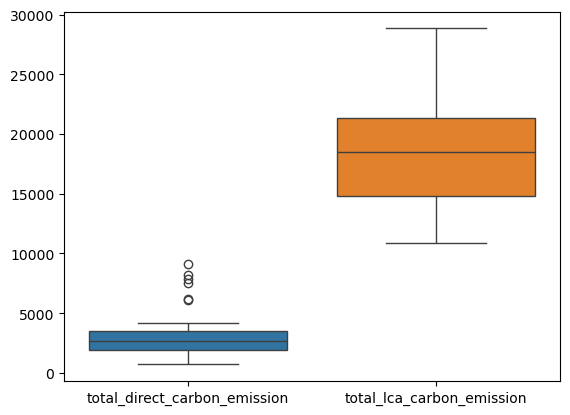

In [9]:
sns.boxplot(se_general[['total_direct_carbon_emission', 'total_lca_carbon_emission']])

<Axes: >

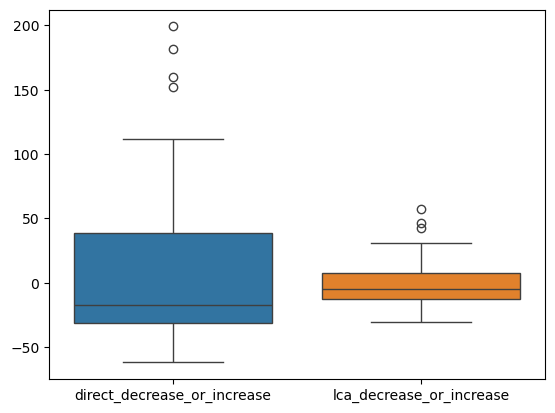

In [10]:
sns.boxplot(se_general[['direct_decrease_or_increase', 'lca_decrease_or_increase']])

In [11]:
se_general[se_general['direct_decrease_or_increase'] > 100]

,year,country,zone_id,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
6,2021,Sweden,SE,7,2005.15,4166.17,107.77,20798.66,23585.59,13.40,70.73,99.42
10,2021,Sweden,SE,11,3002.07,6177.39,105.77,21432.19,25857.41,20.65,69.59,99.22
19,2022,Sweden,SE,8,1356.04,3418.24,152.08,13093.97,17075.58,30.41,66.29,99.73
22,2022,Sweden,SE,11,2619.51,7839.67,199.28,18388.22,28853.64,56.91,70.92,99.56
25,2023,Sweden,SE,2,1838.78,3888.14,111.45,17164.11,22053.45,28.49,72.83,99.69
33,2023,Sweden,SE,10,1246.96,3513.18,181.74,12722.72,18641.62,46.52,70.50,99.80
34,2023,Sweden,SE,11,3513.18,9139.68,160.15,18641.62,26583.19,42.60,68.59,99.43
45,2024,Sweden,SE,10,970.16,2012.75,107.47,11544.65,14742.81,27.70,69.58,99.84


In [12]:
se_general.loc[[33, 34]]

,year,country,zone_id,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
33,2023,Sweden,SE,10,1246.96,3513.18,181.74,12722.72,18641.62,46.52,70.50,99.80
34,2023,Sweden,SE,11,3513.18,9139.68,160.15,18641.62,26583.19,42.60,68.59,99.43


In [13]:
se_general.select_dtypes(include='number').corr()

,year,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
year,1.000000e+00,4.864312e-14,-0.213826,-0.228471,-0.036004,-0.545129,-0.568604,-0.016708,-0.084950,0.449103
month,4.864312e-14,1.000000e+00,-0.108681,0.141075,0.303203,-0.194756,0.028276,0.303026,0.052070,0.108472
total_direct_carbon_emission,-2.138255e-01,-1.086814e-01,1.000000,0.434672,-0.389414,0.860309,0.463777,-0.436840,0.162390,-0.931436
next_direct_carbon_emission,-2.284711e-01,1.410753e-01,0.434672,1.000000,0.544254,0.460330,0.852455,0.490024,0.109036,-0.429692
direct_decrease_or_increase,-3.600438e-02,3.032031e-01,-0.389414,0.544254,1.000000,-0.310645,0.416671,0.948081,0.063634,0.341997
total_lca_carbon_emission,-5.451286e-01,-1.947557e-01,0.860309,0.460330,-0.310645,1.000000,0.683215,-0.379041,0.225221,-0.897935
next_lca_carbon_emission,-5.686038e-01,2.827641e-02,0.463777,0.852455,0.416671,0.683215,1.000000,0.398215,0.235124,-0.573551
lca_decrease_or_increase,-1.670761e-02,3.030260e-01,-0.436840,0.490024,0.948081,-0.379041,0.398215,1.000000,0.037059,0.367367
avg_renewable_percentage,-8.495019e-02,5.206986e-02,0.162390,0.109036,0.063634,0.225221,0.235124,0.037059,1.000000,-0.158951
avg_low_carbon_percentage,4.491033e-01,1.084724e-01,-0.931436,-0.429692,0.341997,-0.897935,-0.573551,0.367367,-0.158951,1.000000


In [14]:
#sns.pairplot(se_general)

## Hourly Analysis

In [15]:
query_se_hourly = '''
WITH se_2021_summary AS (
    SELECT 
        '2021' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM sweden.year_2021_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), se_2022_summary AS (
    SELECT 
        '2022' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM sweden.year_2022_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), se_2023_summary AS (
    SELECT 
        '2023' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM sweden.year_2023_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), se_2024_summary AS (
    SELECT 
        '2024' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM sweden.year_2024_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), total_summary AS (
    SELECT * FROM se_2021_summary
    UNION ALL
    SELECT * FROM se_2022_summary
    UNION ALL
    SELECT * FROM se_2023_summary
    UNION ALL
    SELECT * FROM se_2024_summary
), with_differences AS (
    SELECT 
        *,
        LEAD(total_direct_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, hour_grouped) AS next_direct_carbon_emission,
        LEAD(total_lca_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, hour_grouped) AS next_lca_carbon_emission
    FROM total_summary
)

SELECT 
    year_,
    country,
    zone_id,
    hour_grouped,
    total_direct_carbon_emission,
    next_direct_carbon_emission,
    CASE 
        WHEN next_direct_carbon_emission IS NOT NULL AND total_direct_carbon_emission != 0 
        THEN ROUND(((next_direct_carbon_emission - total_direct_carbon_emission) / total_direct_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS direct_decrease_or_increase,
    total_lca_carbon_emission,
    next_lca_carbon_emission,
    CASE 
        WHEN next_lca_carbon_emission IS NOT NULL AND total_lca_carbon_emission != 0 
        THEN ROUND(((next_lca_carbon_emission - total_lca_carbon_emission) / total_lca_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS lca_decrease_or_increase,
    avg_renewable_percentage,
    avg_low_carbon_percentage
FROM with_differences
ORDER BY year_, hour_grouped
'''

se_hourly = pd.read_sql_query(query_se_hourly, engine)

In [16]:
se_hourly.head(20)

,year_,country,zone_id,hour_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Sweden,SE,0.0,1721.15,1773.76,3.06,10825.15,10917.08,0.85,68.07,99.17
1,2021,Sweden,SE,1.0,1773.76,1883.66,6.20,10917.08,11069.04,1.39,67.54,99.14
2,2021,Sweden,SE,2.0,1883.66,1842.81,-2.17,11069.04,11068.31,-0.01,67.27,99.10
3,2021,Sweden,SE,3.0,1842.81,1810.57,-1.75,11068.31,11143.52,0.68,67.34,99.12
4,2021,Sweden,SE,4.0,1810.57,1910.26,5.51,11143.52,11349.82,1.85,68.05,99.15
5,2021,Sweden,SE,5.0,1910.26,2210.11,15.70,11349.82,11759.23,3.61,69.21,99.11
6,2021,Sweden,SE,6.0,2210.11,2368.91,7.19,11759.23,11995.30,2.01,69.88,99.01
7,2021,Sweden,SE,7.0,2368.91,2404.37,1.50,11995.30,12068.71,0.61,70.12,98.93
8,2021,Sweden,SE,8.0,2404.37,2334.20,-2.92,12068.71,11952.75,-0.96,70.33,98.91
9,2021,Sweden,SE,9.0,2334.20,2247.47,-3.72,11952.75,11858.17,-0.79,70.53,98.93


In [17]:
se_hourly

,year_,country,zone_id,hour_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Sweden,SE,0.0,1721.15,1773.76,3.06,10825.15,10917.08,0.85,68.07,99.17
1,2021,Sweden,SE,1.0,1773.76,1883.66,6.20,10917.08,11069.04,1.39,67.54,99.14
2,2021,Sweden,SE,2.0,1883.66,1842.81,-2.17,11069.04,11068.31,-0.01,67.27,99.10
3,2021,Sweden,SE,3.0,1842.81,1810.57,-1.75,11068.31,11143.52,0.68,67.34,99.12
4,2021,Sweden,SE,4.0,1810.57,1910.26,5.51,11143.52,11349.82,1.85,68.05,99.15
...,...,...,...,...,...,...,...,...,...,...,...,...
91,2024,Sweden,SE,19.0,817.37,783.77,-4.11,6989.13,6886.11,-1.47,70.00,99.73
92,2024,Sweden,SE,20.0,783.77,758.85,-3.18,6886.11,6800.64,-1.24,69.41,99.74
93,2024,Sweden,SE,21.0,758.85,893.17,17.70,6800.64,6917.94,1.72,68.67,99.75
94,2024,Sweden,SE,22.0,893.17,1044.10,16.90,6917.94,7054.74,1.98,67.72,99.71


In [18]:
se_hourly.rename(columns={'year_':'year'}, inplace=True)
se_hourly.rename(columns={'hour_grouped':'hour'}, inplace=True)

In [19]:
se_hourly.year = se_hourly.year.astype(int)
se_hourly.hour = se_hourly.hour.astype(int)

In [20]:
#se_hourly.to_excel('se_hourly.xlsx')

In [21]:
se_hourly.describe()

,year,hour,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
count,96.000000,96.000000,96.000000,95.000000,95.000000,96.000000,95.000000,95.000000,96.000000,96.000000
mean,2022.500000,11.500000,1545.964687,1544.120632,-0.039579,9290.070417,9273.911684,-0.384947,69.376250,99.422813
std,1.123903,6.958524,439.098592,441.054184,9.740733,1510.757068,1510.408861,3.528918,1.340722,0.244195
min,2021.000000,0.000000,758.850000,758.850000,-33.570000,6800.640000,6800.640000,-17.940000,66.430000,98.910000
25%,2021.750000,5.750000,1205.962500,1205.185000,-6.335000,8301.517500,8279.595000,-1.315000,68.350000,99.222500
50%,2022.500000,11.500000,1549.145000,1547.510000,0.000000,8917.920000,8899.740000,-0.190000,69.730000,99.500000
75%,2023.250000,17.250000,1801.952500,1804.825000,6.120000,10276.267500,10089.755000,1.435000,70.415000,99.610000
max,2024.000000,23.000000,2424.990000,2424.990000,21.760000,12068.710000,12068.710000,7.100000,71.580000,99.750000


<Axes: >

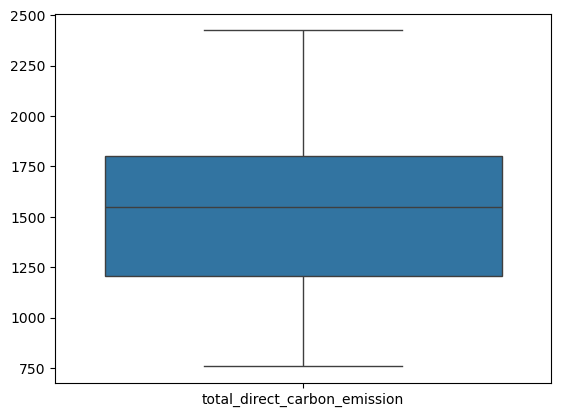

In [22]:
sns.boxplot(se_hourly[['total_direct_carbon_emission']])

In [23]:
se_hourly.total_direct_carbon_emission.max()

2424.99

In [24]:
q1 = se_hourly.total_direct_carbon_emission.quantile(0.25)
q3 = se_hourly.total_direct_carbon_emission.quantile(0.75)

iqr = q3 - q1

inferior_limit = q1 - 1.5 * iqr
superior_limit = q3 + 1.5 * iqr

print(f'IL: {inferior_limit} | SL: {superior_limit}')

IL: 311.9775000000004 | SL: 2695.9374999999995


In [25]:
se_hourly[(se_hourly.total_direct_carbon_emission < inferior_limit) | (se_hourly.total_direct_carbon_emission > superior_limit)]

,year,country,zone_id,hour,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage


In [26]:
se_hourly[(se_hourly.direct_decrease_or_increase >= inferior_limit) & (se_hourly.direct_decrease_or_increase <= superior_limit)].max()

year                            NaN
country                         NaN
zone_id                         NaN
hour                            NaN
total_direct_carbon_emission    NaN
next_direct_carbon_emission     NaN
direct_decrease_or_increase     NaN
total_lca_carbon_emission       NaN
next_lca_carbon_emission        NaN
lca_decrease_or_increase        NaN
avg_renewable_percentage        NaN
avg_low_carbon_percentage       NaN
dtype: object

<Axes: >

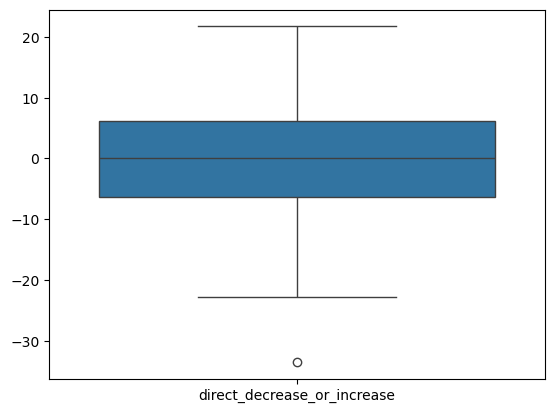

In [27]:
sns.boxplot(se_hourly[['direct_decrease_or_increase']])

In [28]:
se_hourly.select_dtypes(include='number').corr()

,year,hour,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
year,1.000000e+00,2.451147e-14,-0.469814,-0.463248,0.009242,-0.809112,-0.785484,0.060630,-0.143206,0.689031
hour,2.451147e-14,1.000000e+00,-0.286798,-0.306624,-0.061834,-0.095147,-0.161789,-0.414838,0.361391,0.147404
total_direct_carbon_emission,-4.698140e-01,-2.867977e-01,1.000000,0.939418,-0.154086,0.859038,0.836891,-0.062111,0.086745,-0.887553
next_direct_carbon_emission,-4.632479e-01,-3.066237e-01,0.939418,1.000000,0.183929,0.824763,0.860187,0.197267,0.063898,-0.843764
direct_decrease_or_increase,9.242439e-03,-6.183402e-02,-0.154086,0.183929,1.000000,-0.090456,0.065723,0.745217,-0.030652,0.110701
total_lca_carbon_emission,-8.091115e-01,-9.514673e-02,0.859038,0.824763,-0.090456,1.000000,0.975678,-0.072951,0.263911,-0.951705
next_lca_carbon_emission,-7.854844e-01,-1.617889e-01,0.836891,0.860187,0.065723,0.975678,1.000000,0.145744,0.248851,-0.926700
lca_decrease_or_increase,6.062986e-02,-4.148383e-01,-0.062111,0.197267,0.745217,-0.072951,0.145744,1.000000,0.027919,0.079859
avg_renewable_percentage,-1.432065e-01,3.613911e-01,0.086745,0.063898,-0.030652,0.263911,0.248851,0.027919,1.000000,-0.126268
avg_low_carbon_percentage,6.890312e-01,1.474039e-01,-0.887553,-0.843764,0.110701,-0.951705,-0.926700,0.079859,-0.126268,1.000000


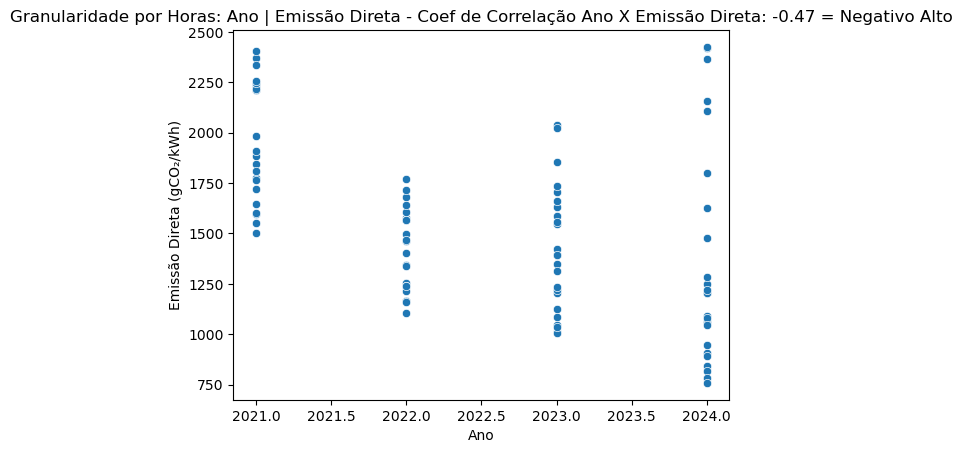

In [29]:
correlation = se_hourly.year.corr(se_hourly.total_direct_carbon_emission)

sns.scatterplot(data=se_hourly, x='year', y='total_direct_carbon_emission')
plt.title(f'Granularidade por Horas: Ano | Emissão Direta - Coef de Correlação Ano X Emissão Direta: {correlation:.2f} = Negativo Alto')
plt.xlabel('Ano')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.show()

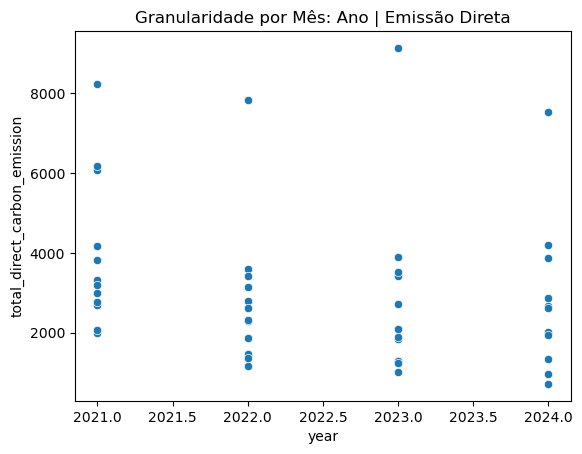

In [30]:
sns.scatterplot(data=se_general, x='year', y='total_direct_carbon_emission')
plt.title('Granularidade por Mês: Ano | Emissão Direta')
plt.show()

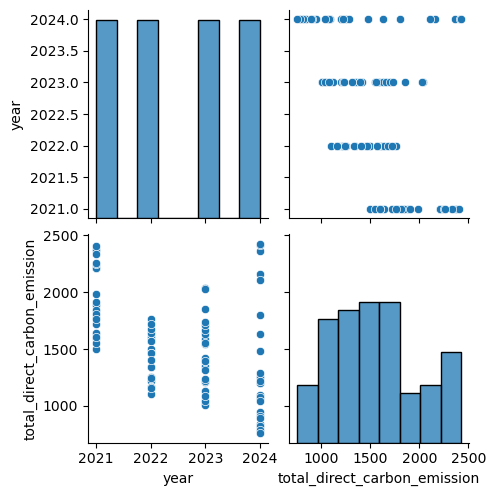

In [31]:
sns.pairplot(se_hourly[['year', 'total_direct_carbon_emission']])

### 2021

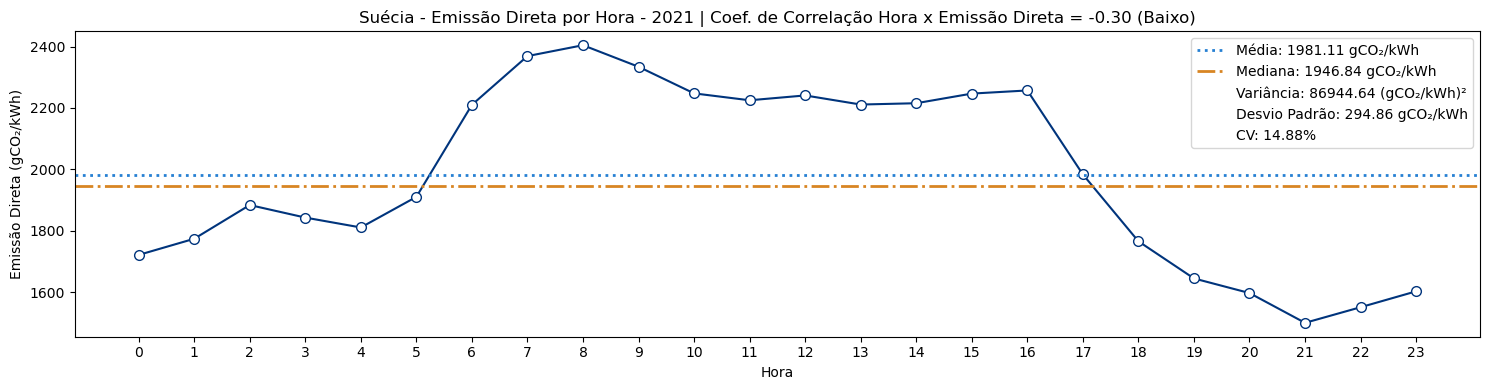

In [32]:
se_hourly_2021 = se_hourly[se_hourly.year == 2021]

correlation = se_hourly_2021.hour.corr(se_hourly_2021.total_direct_carbon_emission)
mean = se_hourly_2021.total_direct_carbon_emission.mean()
median = se_hourly_2021.total_direct_carbon_emission.median()
std = se_hourly_2021.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(se_hourly_2021.hour, se_hourly_2021.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Suécia - Emissão Direta por Hora - 2021 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

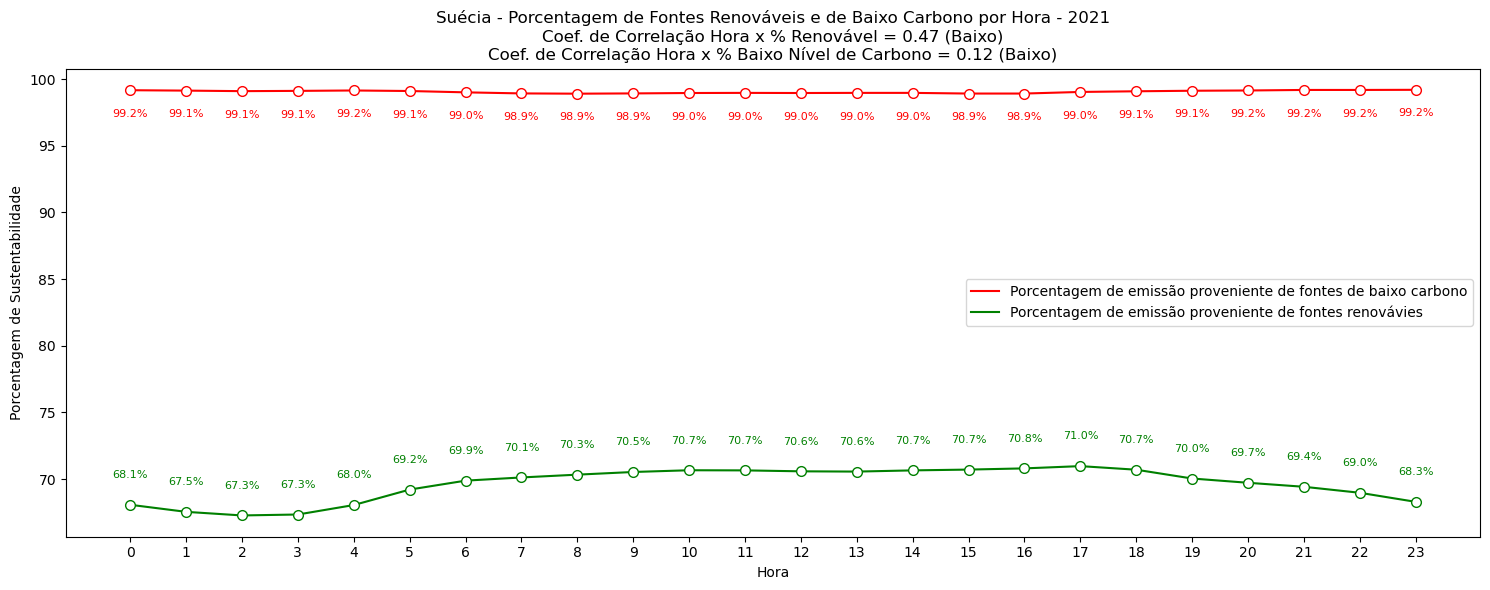

In [52]:
se_hourly_2021 = se_hourly[se_hourly.year == 2021]

correlation_renewable = se_hourly_2021.hour.corr(se_hourly_2021.avg_renewable_percentage)
correlation_low_carbon = se_hourly_2021.hour.corr(se_hourly_2021.avg_low_carbon_percentage)

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)

plt.plot(se_hourly_2021.hour, se_hourly_2021.avg_renewable_percentage, 
         linewidth=1.5, color='green', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(se_hourly_2021.hour, se_hourly_2021.avg_renewable_percentage):
    plt.text(x, y + 2, f'{y:.1f}%', ha='center', fontsize=8, color='green')

plt.plot(se_hourly_2021.hour, se_hourly_2021.avg_low_carbon_percentage, 
         linewidth=1.5, color='red', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(se_hourly_2021.hour, se_hourly_2021.avg_low_carbon_percentage):
    plt.text(x, y - 2, f'{y:.1f}%', ha='center', fontsize=8, color='red')

custom_lines = [
    Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
    Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(
    f'Suécia - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2021\n'
    f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
    f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
)
plt.xlabel('Hora')
plt.ylabel('Porcentagem de Sustentabilidade')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

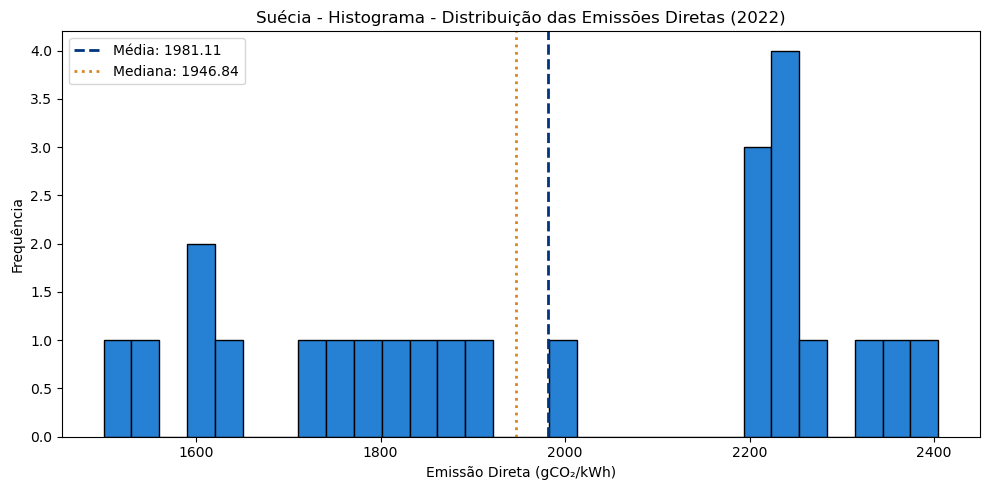

In [34]:
plt.figure(figsize=(10, 5))
plt.hist(se_hourly_2021.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(se_hourly_2021.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {se_hourly_2021.total_direct_carbon_emission.mean():.2f}')
plt.axvline(se_hourly_2021.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {se_hourly_2021.total_direct_carbon_emission.median():.2f}')
plt.title('Suécia - Histograma - Distribuição das Emissões Diretas (2022)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

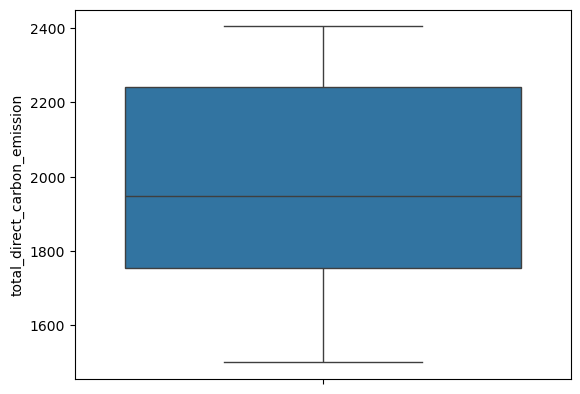

In [35]:
sns.boxplot(se_hourly_2021.total_direct_carbon_emission)

In [36]:
se_hourly.groupby('hour')['total_direct_carbon_emission'].max().reset_index().sort_values('total_direct_carbon_emission', ascending=False)

,hour,total_direct_carbon_emission
12,12,2424.99
11,11,2417.32
8,8,2404.37
7,7,2368.91
10,10,2363.91
9,9,2334.20
16,16,2256.97
15,15,2246.76
14,14,2215.37
13,13,2211.09


### 2022

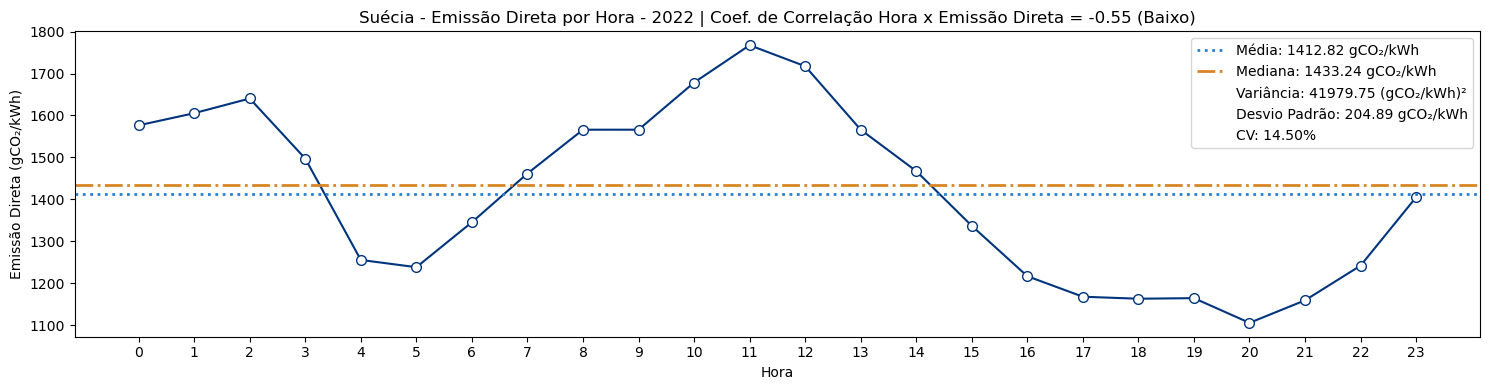

In [37]:
se_hourly_2022 = se_hourly[se_hourly.year == 2022]

correlation = se_hourly_2022.hour.corr(se_hourly_2022.total_direct_carbon_emission)
mean = se_hourly_2022.total_direct_carbon_emission.mean()
median = se_hourly_2022.total_direct_carbon_emission.median()
std = se_hourly_2022.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(se_hourly_2022.hour, se_hourly_2022.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Suécia - Emissão Direta por Hora - 2022 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

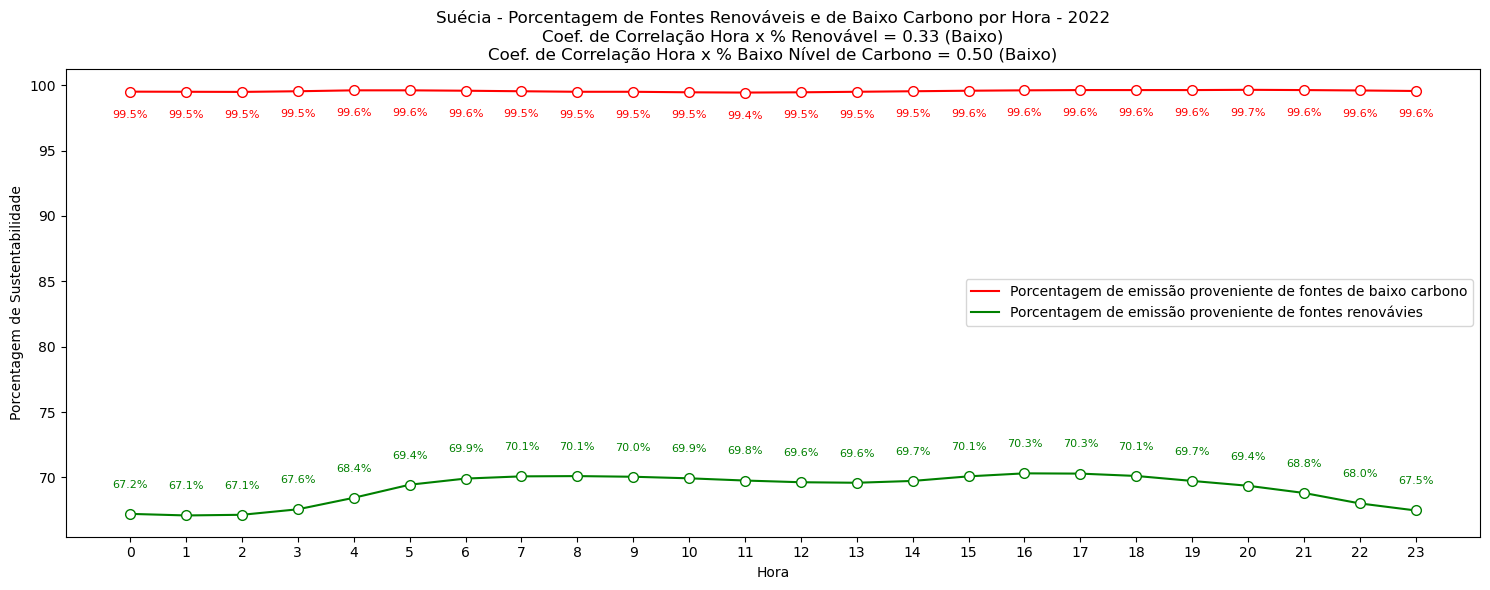

In [54]:
se_hourly_2022 = se_hourly[se_hourly.year == 2022]

correlation_renewable = se_hourly_2022.hour.corr(se_hourly_2022.avg_renewable_percentage)
correlation_low_carbon = se_hourly_2022.hour.corr(se_hourly_2022.avg_low_carbon_percentage)

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)

plt.plot(se_hourly_2022.hour, se_hourly_2022.avg_renewable_percentage, 
         linewidth=1.5, color='green', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(se_hourly_2022.hour, se_hourly_2022.avg_renewable_percentage):
    plt.text(x, y + 2, f'{y:.1f}%', ha='center', fontsize=8, color='green')

plt.plot(se_hourly_2022.hour, se_hourly_2022.avg_low_carbon_percentage, 
         linewidth=1.5, color='red', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(se_hourly_2022.hour, se_hourly_2022.avg_low_carbon_percentage):
    plt.text(x, y - 2, f'{y:.1f}%', ha='center', fontsize=8, color='red')

custom_lines = [
    Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
    Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(
    f'Suécia - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2022\n'
    f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
    f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
)
plt.xlabel('Hora')
plt.ylabel('Porcentagem de Sustentabilidade')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

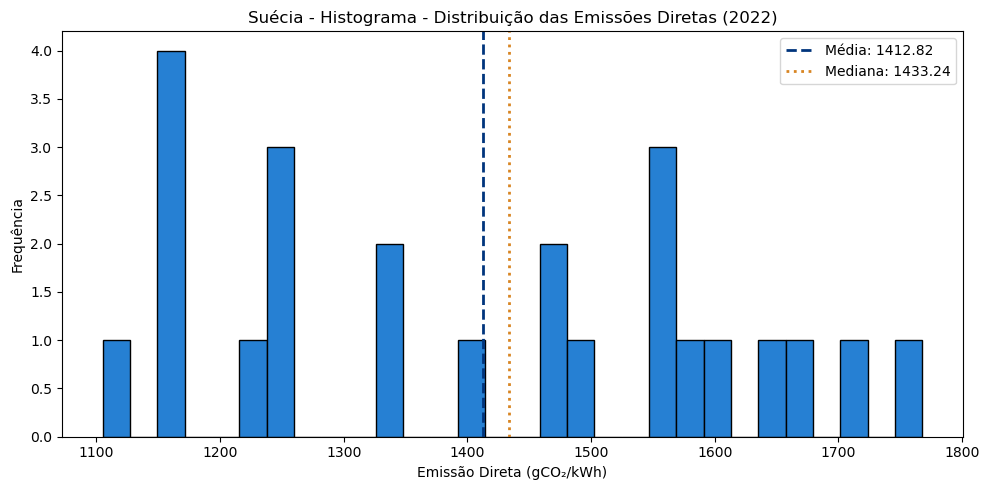

In [39]:
plt.figure(figsize=(10, 5))
plt.hist(se_hourly_2022.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(se_hourly_2022.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {se_hourly_2022.total_direct_carbon_emission.mean():.2f}')
plt.axvline(se_hourly_2022.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {se_hourly_2022.total_direct_carbon_emission.median():.2f}')
plt.title('Suécia - Histograma - Distribuição das Emissões Diretas (2022)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

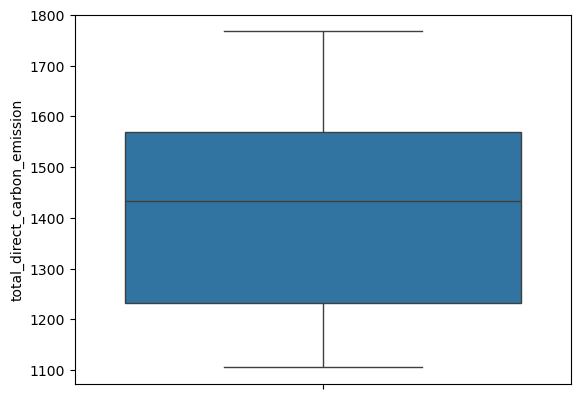

In [40]:
sns.boxplot(se_hourly_2022.total_direct_carbon_emission)

### 2023

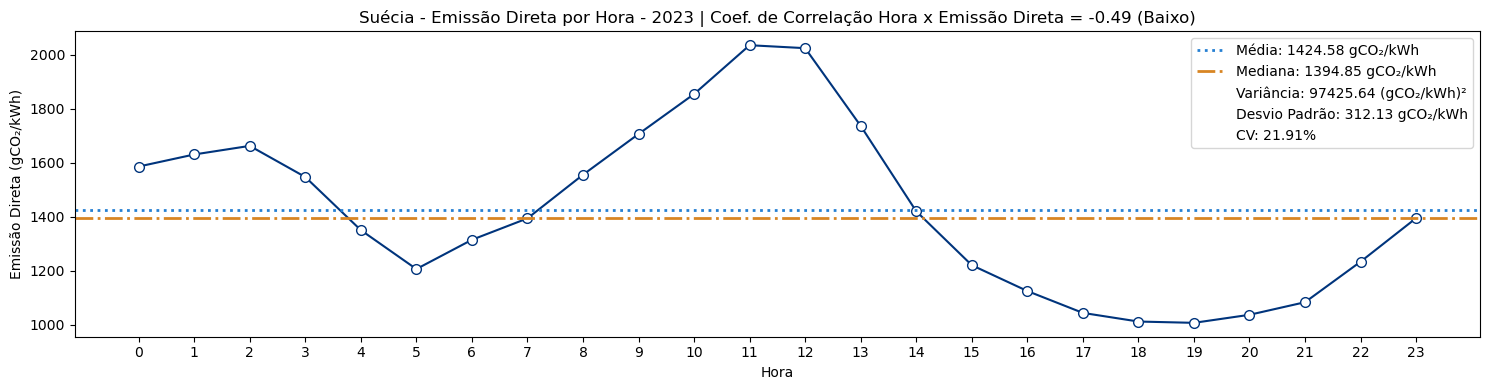

In [41]:
se_hourly_2023 = se_hourly[se_hourly.year == 2023]

correlation = se_hourly_2023.hour.corr(se_hourly_2023.total_direct_carbon_emission)
mean = se_hourly_2023.total_direct_carbon_emission.mean()
median = se_hourly_2023.total_direct_carbon_emission.median()
std = se_hourly_2023.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(se_hourly_2023.hour, se_hourly_2023.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Suécia - Emissão Direta por Hora - 2023 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

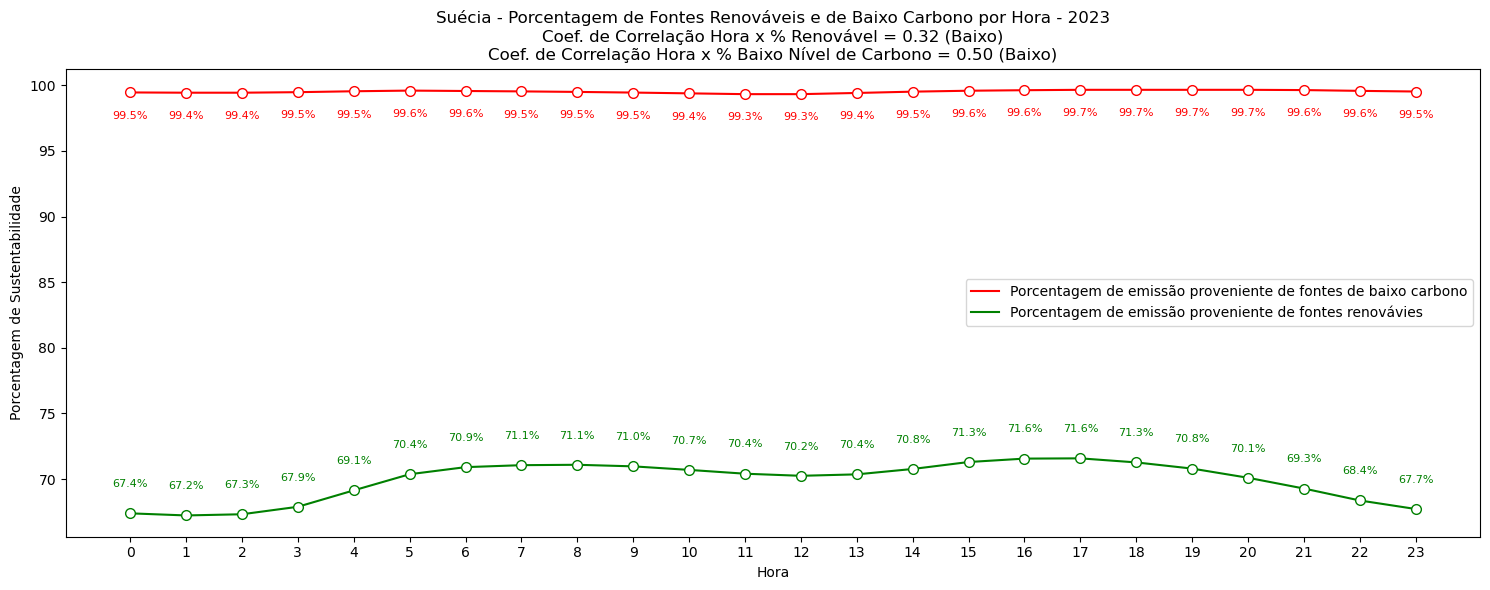

In [55]:
se_hourly_2023 = se_hourly[se_hourly.year == 2023]

correlation_renewable = se_hourly_2023.hour.corr(se_hourly_2023.avg_renewable_percentage)
correlation_low_carbon = se_hourly_2023.hour.corr(se_hourly_2023.avg_low_carbon_percentage)

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)

plt.plot(se_hourly_2023.hour, se_hourly_2023.avg_renewable_percentage, 
         linewidth=1.5, color='green', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(se_hourly_2023.hour, se_hourly_2023.avg_renewable_percentage):
    plt.text(x, y + 2, f'{y:.1f}%', ha='center', fontsize=8, color='green')

plt.plot(se_hourly_2023.hour, se_hourly_2023.avg_low_carbon_percentage, 
         linewidth=1.5, color='red', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(se_hourly_2023.hour, se_hourly_2023.avg_low_carbon_percentage):
    plt.text(x, y - 2, f'{y:.1f}%', ha='center', fontsize=8, color='red')

custom_lines = [
    Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
    Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(
    f'Suécia - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2023\n'
    f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
    f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
)
plt.xlabel('Hora')
plt.ylabel('Porcentagem de Sustentabilidade')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

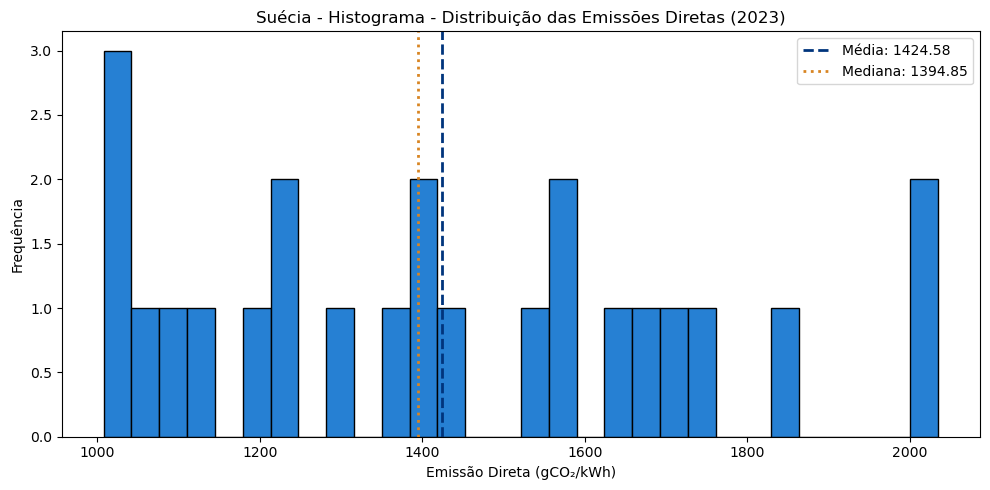

In [43]:
plt.figure(figsize=(10, 5))
plt.hist(se_hourly_2023.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(se_hourly_2023.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {se_hourly_2023.total_direct_carbon_emission.mean():.2f}')
plt.axvline(se_hourly_2023.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {se_hourly_2023.total_direct_carbon_emission.median():.2f}')
plt.title('Suécia - Histograma - Distribuição das Emissões Diretas (2023)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

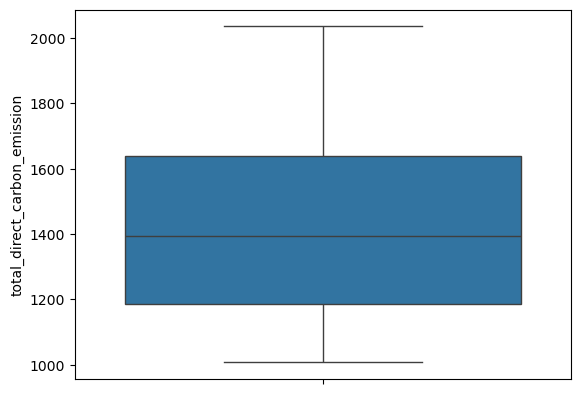

In [44]:
sns.boxplot(se_hourly_2023.total_direct_carbon_emission)

### 2024

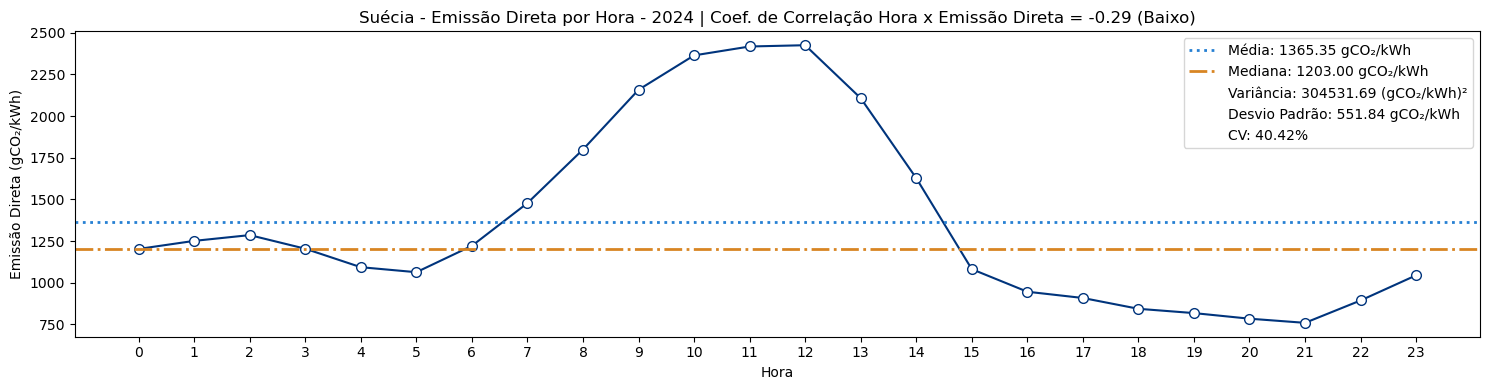

In [45]:
se_hourly_2024 = se_hourly[se_hourly.year == 2024]

correlation = se_hourly_2024.hour.corr(se_hourly_2024.total_direct_carbon_emission)
mean = se_hourly_2024.total_direct_carbon_emission.mean()
median = se_hourly_2024.total_direct_carbon_emission.median()
std = se_hourly_2024.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(se_hourly_2024.hour, se_hourly_2024.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Suécia - Emissão Direta por Hora - 2024 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

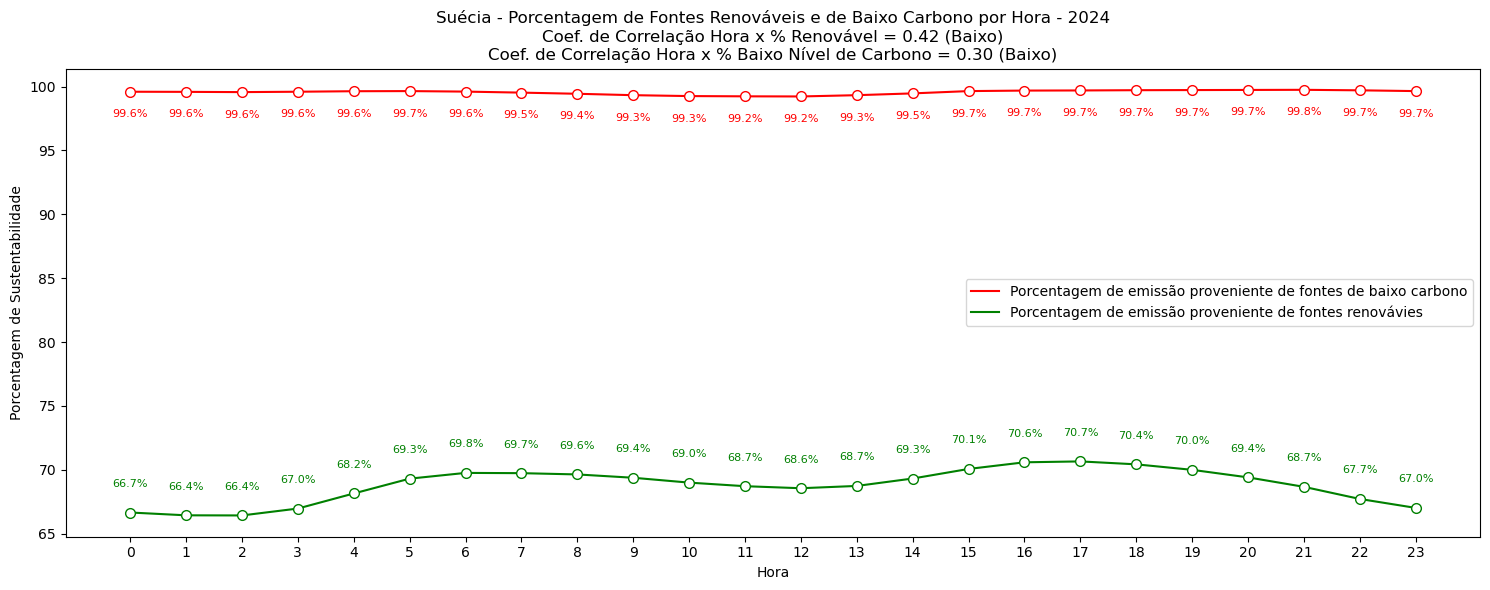

In [56]:
se_hourly_2024 = se_hourly[se_hourly.year == 2024]

correlation_renewable = se_hourly_2024.hour.corr(se_hourly_2024.avg_renewable_percentage)
correlation_low_carbon = se_hourly_2024.hour.corr(se_hourly_2024.avg_low_carbon_percentage)

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)

plt.plot(se_hourly_2024.hour, se_hourly_2024.avg_renewable_percentage, 
         linewidth=1.5, color='green', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(se_hourly_2024.hour, se_hourly_2024.avg_renewable_percentage):
    plt.text(x, y + 2, f'{y:.1f}%', ha='center', fontsize=8, color='green')

plt.plot(se_hourly_2024.hour, se_hourly_2024.avg_low_carbon_percentage, 
         linewidth=1.5, color='red', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(se_hourly_2024.hour, se_hourly_2024.avg_low_carbon_percentage):
    plt.text(x, y - 2, f'{y:.1f}%', ha='center', fontsize=8, color='red')

custom_lines = [
    Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
    Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(
    f'Suécia - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2024\n'
    f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
    f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
)
plt.xlabel('Hora')
plt.ylabel('Porcentagem de Sustentabilidade')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

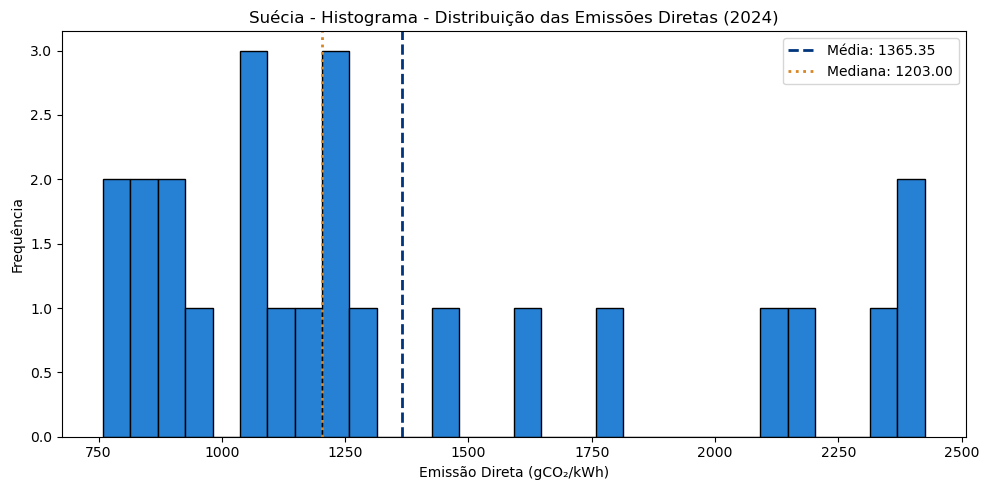

In [47]:
plt.figure(figsize=(10, 5))
plt.hist(se_hourly_2024.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(se_hourly_2024.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {se_hourly_2024.total_direct_carbon_emission.mean():.2f}')
plt.axvline(se_hourly_2024.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {se_hourly_2024.total_direct_carbon_emission.median():.2f}')
plt.title('Suécia - Histograma - Distribuição das Emissões Diretas (2024)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

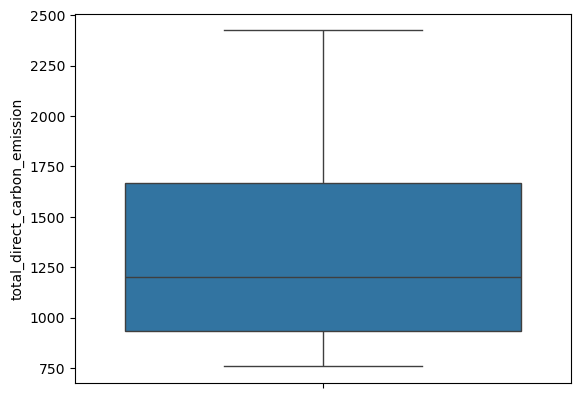

In [48]:
sns.boxplot(se_hourly_2024.total_direct_carbon_emission)